# Time Series Reversibility

I show two measures for time series reversibility. A time series is reversible when the statistical properties are preserved when series is reversed. High values of these measure indicate irreversibility.  Irreversibility gives us an implicit measure for nonlinear dynamics in the price/input. 

The two measures are quite different computationally but have similar outputs. One is based on horizontal visibility graphs while the other is based on permutation/ordinal patterns.

* Tutorial: [Time Series Reversibility | Algorithmic Trading Indicators in Python](https://www.youtube.com/watch?v=W8kfC0NhKEw)
* Full Code: https://github.com/neurotrader888/TimeSeriesReversibility

Links
- https://en.wikipedia.org/wiki/Logistic_map
- https://en.wikipedia.org/wiki/Time_reversibility
- https://en.wikipedia.org/wiki/Kullback–Leibler_divergence

Citations
- [Yang, P., Shang, P. Relative asynchronous index: a new measure for time series irreversibility. Nonlinear Dyn 93, 1545–1557 (2018).](https://link.springer.com/article/10.1007/s11071-018-4275-1)
- [Zanin M, Rodríguez-González A, Menasalvas Ruiz E, Papo D. Assessing Time Series Reversibility through Permutation Patterns. Entropy. 2018; 20(9):665.](https://www.mdpi.com/1099-4300/20/9/665)
- Zanin M, Papo D. Algorithmic Approaches for Assessing Irreversibility in Time Series: Review and Comparison. Entropy (Basel). 2021 Nov 8;23(11):1474. doi: 10.3390/e23111474. PMID: 34828172; PMCID: PMC8622570.

In [1]:
import pandas as pd
import numpy as np
import scipy
import math

from ts2vg import HorizontalVG
import matplotlib.pyplot as plt

In [2]:
def ordinal_patterns(arr: np.array, d: int) -> np.array:
    assert(d >= 2)
    fac = math.factorial(d);
    d1 = d - 1
    mults = []
    for i in range(1, d):
        mult = fac / math.factorial(i + 1)
        mults.append(mult)

    # Create array to put ordinal pattern in
    ordinals = np.empty(len(arr))
    ordinals[:] = np.nan

    for i in range(d1, len(arr)):
        dat = arr[i - d1:  i+1]
        pattern_ordinal = 0
        for l in range(1, d):
            count = 0
            for r in range(l):
                if dat[d1 - l] >= dat[d1 - r]:
                   count += 1

            pattern_ordinal += count * mults[l - 1]
        ordinals[i] = int(pattern_ordinal)

    return ordinals

def perm_ts_reversibility(arr: np.array):
    # Zanin, M.; Rodríguez-González, A.; Menasalvas Ruiz, E.; Papo, D. Assessing time series reversibility through permutation
    
    # Should be fairly large array, very least ~60
    assert(len(arr) >= 10)
    rev_arr = np.flip(arr)
   
    # [2:] drops 2 nan values off start of val
    pats = ordinal_patterns(arr, 3)[2:].astype(int)
    r_pats = ordinal_patterns(rev_arr, 3)[2:].astype(int)
   
    # pdf of patterns, forward and reverse time
    n = len(arr) - 2
    p_f = np.bincount(pats, minlength=6) / n 
    p_r = np.bincount(r_pats, minlength=6) / n

    if min(np.min(p_f), np.min(p_r)) > 0.0:
        rev = scipy.special.rel_entr(p_f, p_r).sum()
    else:
        rev = np.nan
        
    return rev


def async_index(arr1: np.array, arr2: np.array):
    # Computes asynchronous index (AI) from arr1 -> arr2
    # Note AI(arr1, arr2) != AI(arr2, arr1)
    # (Not always !=, but it can be !=)
    assert(len(arr1) == len(arr2))

    n = len(arr1)
    perm = np.argsort(arr1)

    norm_const = (n * (n - 1)) / 2.0

    # Compute async index
    inversion_n = 0
    for i in range(n):
        for j in range(i+1, n):
            diff = arr2[perm[i]] - arr2[perm[j]] 
            if diff > 0:
                inversion_n += 1 # Possibly add weighting to this 1

    return inversion_n / norm_const


def relative_async_index(arr: np.array):
    n = arr.shape[0]

    hvg_f = HorizontalVG()
    hvg_r = HorizontalVG()
    hvg_f.build(arr)
    hvg_r.build(np.flip(arr))

    hvg_f = hvg_f.adjacency_matrix()
    hvg_r = hvg_r.adjacency_matrix()
    
    # Find out-going links from forward and reverse time series
    out_f = np.zeros(n, dtype=int)
    out_r = np.zeros(n, dtype=int)
    for i in range(n):
        out_f[i] = np.sum(hvg_f[i, i:])
        out_r[i] = np.sum(hvg_r[i, i:])
    
    f_r = async_index(out_f, out_r)
    r_f = async_index(out_r, out_f)

    rai = -np.log(min(f_r, r_f) / max(f_r, r_f))
    return rai

def logistic_map(n: int, init: float = 0.49, mu: float = -1.87):
    # For more info go to 
    # https://en.wikipedia.org/wiki/Logistic_map 
    arr = np.zeros(n)
    arr[0] = init
    for i in range(1, n):
        arr[i] = mu * arr[i-1] * (1 - arr[i-1])
    return arr

def henon_map(n: int, init: float = 0.618, a: float = 1.4, b: float = 0.3):
    # https://en.wikipedia.org/wiki/Logistic_map
    y = 0.1
    x = init
    y_ = x_ = 0 # Next x,y

    arr = np.zeros(n)
    for i in range(n):
        x_ = 1 - a * x ** 2 + y
        y_ = b * y
        x, y = x_, y_
        arr[i] = x

    return arr

In [3]:
# This test is not rigourous, think of it as a toy.
# https://doi.org/10.1007/s11071-018-4275-1 
# is more rigourous.. 

# sine, reversible

n = 240
wave = np.sin( 2 * np.pi * (1/12) * np.arange(n) )

# Logistic map, irreversible
lm = logistic_map(n, init=0.5)

print("Sine RAI", relative_async_index(wave))
print("Logistic RAI", relative_async_index(lm))

# Sine wave reversibility measured by RAI differs by length of series at smaller values.
# Showing there is an amount of 'noise' in the resulting value
# try n = 100 or other vals. Smoothing might be necessary for smaller lookback windows when 
# used as an indicator...

Sine RAI 0.0031219216943458414
Logistic RAI 0.1495855041288554


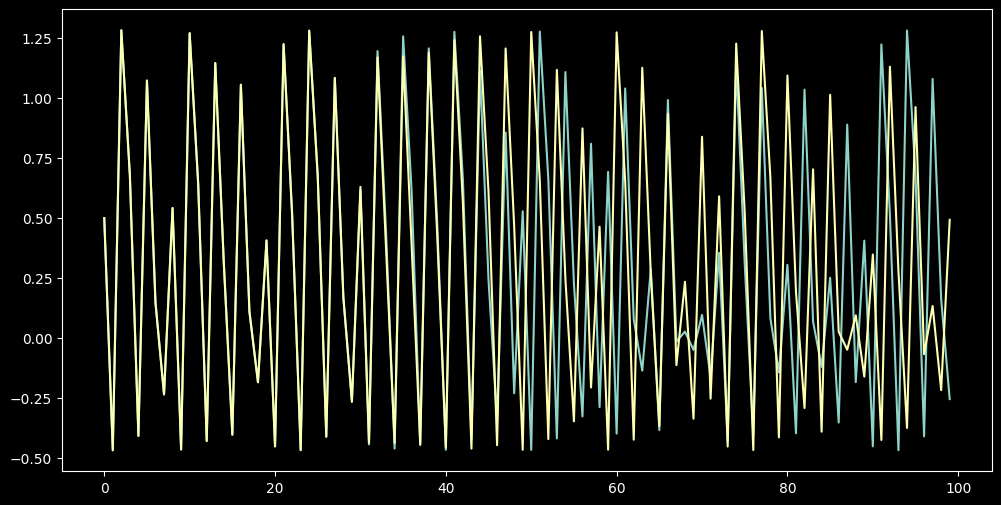

In [4]:
# simple example of butterfly effect, off topic but cool
lm1 = logistic_map(100, init=0.5)
lm2 = logistic_map(100, init=0.5001) # Small change in initial conditions

plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
# The two are similar at first, but diverge eventually
pd.Series(lm1).plot()
pd.Series(lm2).plot()
plt.show()

In [5]:
%%time
# sine, reversible. RAI on sin approaches 0 as length approaches inifinity
for x in [50, 100, 200, 400, 800, 1200, 2400, 10000]: 
    wave = np.sin( 2 * np.pi * (1/12) * np.arange(x) )
    rai = relative_async_index(wave)
    print(rai)

0.048439962800067585
0.0790137951432126
0.1638594939542192
0.004898154952748381
0.00366109195541928
0.00313428404857222
0.00272003709482946
1.5013223798563807e-06
CPU times: user 25.7 s, sys: 49 ms, total: 25.7 s
Wall time: 25.7 s


In [6]:
def rw_ptsr(arr: np.array, lookback: int):
    # Rolling window permutation time series reversibility
    rev = np.zeros(len(arr))
    rev[:] = np.nan
    
    lookback_ = lookback + 2
    for i in range(lookback_, len(arr)):
        dat = arr[i - lookback_ + 1: i+1]
        rev_w = perm_ts_reversibility(dat) 

        if np.isnan(rev_w):
            rev[i] = rev[i - 1]
        else:
            rev[i] = rev_w

    return rev

def rw_rai(arr: np.array, lookback: int):
    # Rolling window relative asynchronous index
    rev = np.zeros(len(arr))
    rev[:] = np.nan
    
    for i in range(lookback, len(arr)):
        dat = arr[i - lookback + 1: i+1]
        rev_w = relative_async_index(dat) 
        rev[i] = rev_w

    return rev

In [7]:
# Load data
data = pd.read_csv('src/BTCUSDT86400.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')

In [8]:
%%time
# You could use changes in price instead.  
data['d'] = np.log(data['close']).diff()

lb = 365
data['rai'] =  rw_rai(data['close'].to_numpy(), lb)
data['ptsr'] =  rw_ptsr(data['close'].to_numpy(), lb)
data['rai_s'] = data['rai'].ewm(7).mean()

CPU times: user 46.6 s, sys: 1.65 s, total: 48.3 s
Wall time: 46.7 s


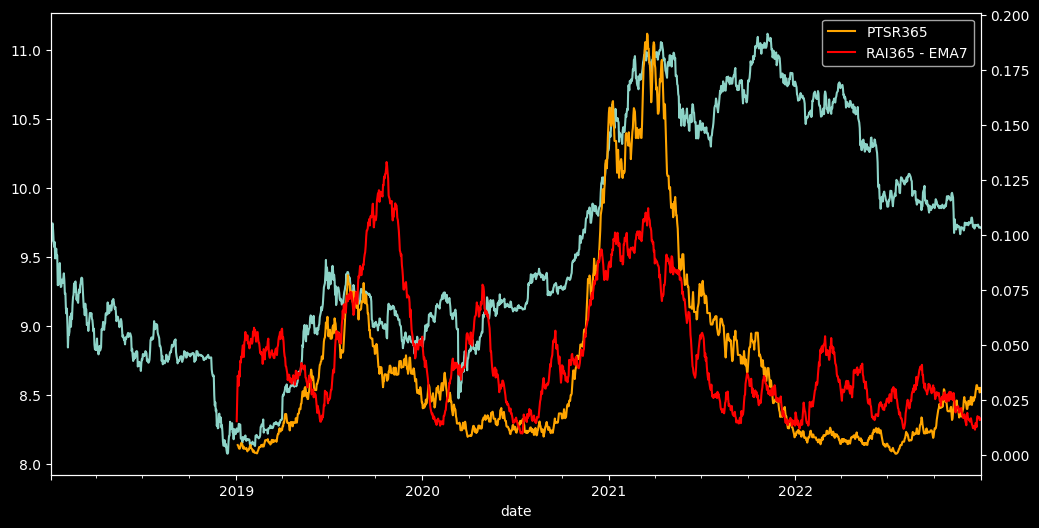

In [9]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 6))
np.log(data['close']).plot()
plt.twinx()
data['ptsr'].plot(color='orange', label='PTSR365')
#data['rai'].plot(color='orange', label='RAI365')
data['rai'].ewm(7).mean().plot(color='red', label='RAI365 - EMA7')
plt.legend()